# 시계열 분석_실습

# Step0. 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime

# Step1. 분석에 필요한 데이터 구성하기

In [2]:
ds_currency = pd.read_csv("환율.csv", engine = "python", parse_dates = ["APPL_DATE"])
ds_currency.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


In [3]:
ds_currency_USD = ds_currency[ds_currency["CURRENCY"] == "USD"].set_index("APPL_DATE")
ds_currency_USD.drop(["CURRENCY", "USD_CONV_DATE"], axis = 1, inplace = True)
ds_currency_USD.head()

,STD_RATE
APPL_DATE,
2016-01-01,1178.0
2016-01-02,1178.0
2016-01-03,1178.0
2016-01-04,1184.0
2016-01-05,1185.0


# Step2. 변동 추세 확인

### 시간에 따른 환율 추세 그래프 생성

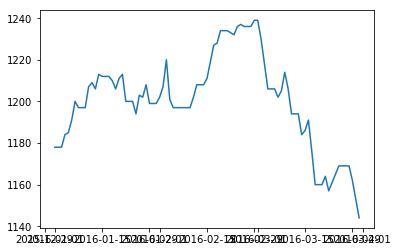

In [16]:
plt.plot( ds_currency_USD.index, ds_currency_USD.STD_RATE)

# Step3. 시계열 분석-정상성 확인/ 자기상관성 확인

### 차분을 통하여 정상성 데이터로 변환

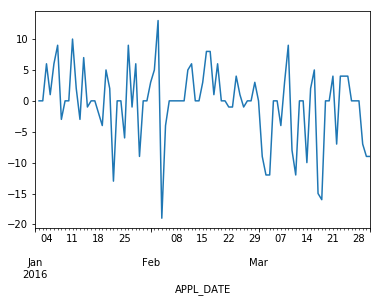

In [18]:
ds_usd_diff1 = ds_currency_USD["STD_RATE"] - ds_currency_USD["STD_RATE"].shift(1)
ds_usd_diff1.plot()

### 원 데이터보다는 시간의 흐름에 영향을 덜 받지만, 아직 정상성을 만족하지 않음

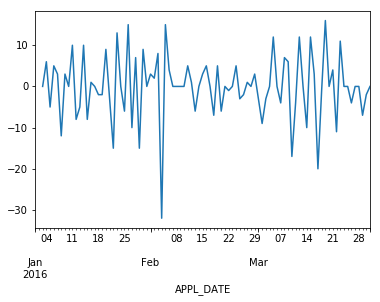

In [19]:
ds_usd_diff2 = ds_currency_USD["STD_RATE"] - 2*(ds_currency_USD["STD_RATE"].shift(1)) + (ds_currency_USD["STD_RATE"].shift(2))
ds_usd_diff2.plot()

### 시간의 흐름에 영향을 받지 않아 정상성을 만족

## 자기상관 함수 및 부분 자기상관 함수

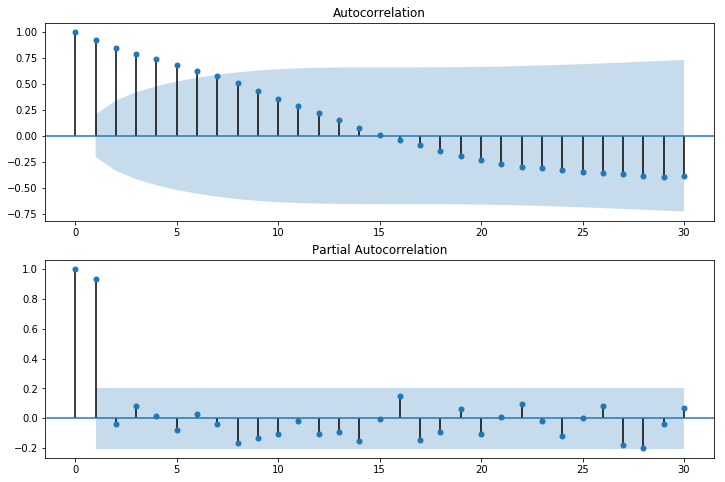

In [20]:
lag_size = 30
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(ds_currency_USD["STD_RATE"], lags = lag_size, ax = ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(ds_currency_USD["STD_RATE"], lags = lag_size, ax = ax2)

### ACF가 감소하며, PACF가 2 시점에서 절단면을 갖는다면, 1시점 전의 자료가 현재에 영향을 미친다. AR(1)모델

## 시계열 분석

In [21]:
ts_model_usd = ARIMA(ds_currency_USD, order = (1, 2, 0))
ts_result_usd = ts_model_usd.fit(trend= 'c', full_output = True, disp = 1)
print(ts_result_usd.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   89
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -302.442
Method:                       css-mle   S.D. of innovations              7.231
Date:                Sun, 10 Feb 2019   AIC                            610.884
Time:                        17:49:45   BIC                            618.350
Sample:                    01-03-2016   HQIC                           613.893
                         - 03-31-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.1017      0.559     -0.182      0.856      -1.198       0.994
ar.L1.D2.STD_RATE    -0.3751      0.097     -3.853      0.000      -0.566      -0.184
                        

/Users/jeong-utae/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/jeong-utae/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/jeong-utae/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


# Step4. 예측 및 결과 해석

/Users/jeong-utae/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


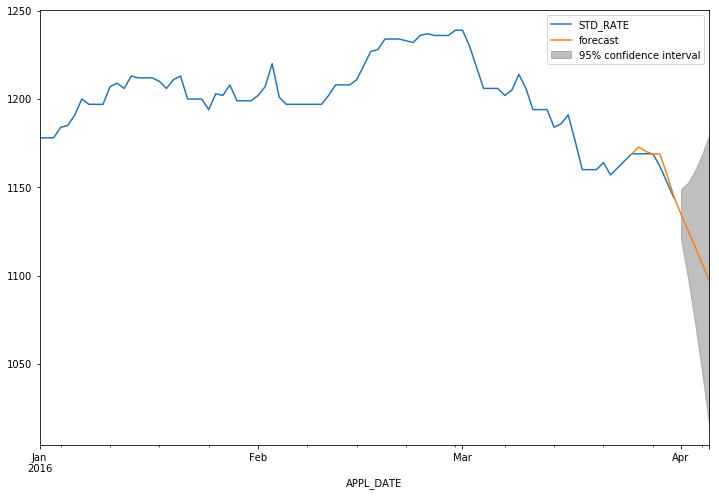

In [23]:
start_time = datetime.strptime("2016-03-25T00:00:00", "%Y-%m-%dT%H:%M:%S")
end_time = datetime.strptime("2016-04-05T00:00:00", "%Y-%m-%dT%H:%M:%S")
fig, ax = plt.subplots(figsize= (12, 8))
ax = ds_currency_USD.plot(ax = ax)
fig = ts_result_usd.plot_predict(start = start_time, end = end_time, ax= ax, plot_insample = False)

### 2016년 4월 5일까지의 예측값, 미국 달러 환율은 지속적으로 감소할 것으로 예상